In [3]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import accuracy_score

In [4]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

# process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

Loaded the dataset with 118 features and 3064705 curves..


In [5]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df[df['sha'] == 9].shape[0]
# df_balanced = df[df['sha'] == 1].sample(len_4) 
df_balanced = df[df['sha'] == 4].iloc[:len_9]
df_balanced = pd.concat([df_balanced, df[df['sha'] == 9]])
df_balanced.sha.value_counts()

# rename 4 to 0 and 9 to 1
df_balanced['sha'] = df_balanced['sha'].replace({4: 0, 9: 1})

# logistic regression

In [16]:
# use logistic regression model to classify the
# import logistic regression model
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into training and testing
X = df_balanced.drop('sha', axis=1)
y = df_balanced['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

0.5656355344041245

# NN

In [17]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
# hidden_units = [32,16,8]
# hidden_units = [16,8,4]
hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 118 and the output dimension is 2.
Device: cpu.
The model has 1,032 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=118, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4, out_features=2, bias=True)
    (7): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=2, out_features=2, bias=True)
  )
)


In [20]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 10
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/10, Training accuracy_score: 0.8034306677903922, Validation accuracy_score: 0.8066531158594021
Epoch 2/10, Training accuracy_score: 0.800621354089204, Validation accuracy_score: 0.8050171037628279
Epoch 3/10, Training accuracy_score: 0.8246492489217193, Validation accuracy_score: 0.828664914976947
Epoch 4/10, Training accuracy_score: 0.7806917521854808, Validation accuracy_score: 0.7855336869763522
Epoch 5/10, Training accuracy_score: 0.8055128650042139, Validation accuracy_score: 0.8088840414456397
Epoch 6/10, Training accuracy_score: 0.8191462991423331, Validation accuracy_score: 0.8226662039561747
Epoch 7/10, Training accuracy_score: 0.7848726719878373, Validation accuracy_score: 0.7888552872936394
Epoch 8/10, Training accuracy_score: 0.777832862360154, Validation accuracy_score: 0.7813692925487086
Epoch 9/10, Training accuracy_score: 0.7815841224199759, Validation accuracy_score: 0.7860790243418769
Epoch 10/10, Training accuracy_score: 0.7983573777535405, Validation accurac

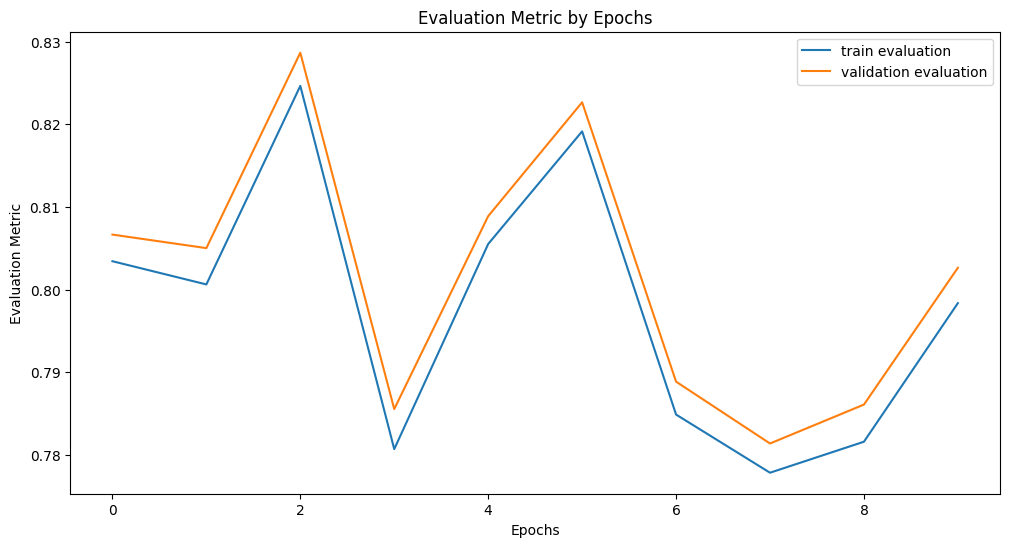

In [21]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [22]:
executor.test(model, test_dataset, evaluator, if_regression = False)

0.8293178663493952

# just load a trained model and see the result

In [8]:
# # load data
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
# df = utils.load_data(path)

# # load torch model
# import torch
# model = torch.load(Path("..") / "trained_models" / "model.pth")

# # split data
# train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# X_test, y_test = test_dataset.tensors

# # test the model
# model.eval()
# outputs = model(X_test)
# y_pred = outputs.squeeze()

# # get the l1 distance between the predicted and actual values
# loss = torch.nn.L1Loss()
# loss(y_pred, y_test)